#**Практическое задание №1**

In [3]:
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Установка необходимых пакетов:

In [4]:
!pip install -q libtiff
!pip install -q tqdm

     |████████████████████████████████| 133kB 5.2MB/s 


Монтирование Вашего Google Drive к текущему окружению:

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


В переменную PROJECT_DIR необходимо прописать путь к директории на Google Drive, в которую Вы загрузили zip архивы с предоставленными наборами данных.

In [6]:
# todo
PROJECT_DIR = 'speccourse_task/'

Константы, которые пригодятся в коде далее:

In [7]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
VAL_PROPORTION = 0.1
BATCH_SIZE = 128
EPOCHS = 40
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')

Импорт необходимых зависимостей:

In [8]:
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from libtiff import TIFF
from skimage.io import imsave, imread
import os
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gc

---
### Класс Dataset

Предназначен для работы с наборами данных, хранящихся на Google Drive, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [9]:
def preprocess_img(img, label=0):
    
    # img = img.numpy()
    # means = tf.reduce_mean(img, axis=(-3, -2))
    means = np.mean(img, axis=(-3, -2))
    # deviations = tf.reduce_std(img, axis=(-3, -2))
    deviations = np.std(img, axis=(-3, -2))
    img = (img - means) / deviations
    
    return img, label

class Dataset:

    def __init__(self, name, gdrive_dir):
        self.name = name
        self.is_loaded = False
        p = Path("/content/drive/MyDrive/" + gdrive_dir + name + '.npz') 
        if p.exists():
            print(f'Loading dataset {self.name} from npz.')
            np_obj = np.load(str(p))
            self.images = np_obj['data']
            self.labels = np_obj['labels']
            self.n_files = self.images.shape[0]
            self.is_loaded = True
            self.dir_to_save = None
            print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def create_tf_dataset(self, pattern='*', preprocess=False):

        if preprocess:
            print('Preprocessing started')
            for i, img in enumerate(self.images):
                self.images[i], _ = preprocess_img(self.images[i])
            print('Preprocessing finished')

        return tf.data.Dataset.from_tensor_slices((self.images, self.labels))#.map(preprocess_img)

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]
  
    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Loading dataset test_small from npz.
Done. Dataset test_small consists of 1800 images.

Got numpy array of shape (224, 224, 3), and label with code 4.
Label code corresponds to MUC class.


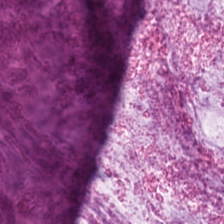

In [ ]:
d_train_tiny = Dataset('test_small', PROJECT_DIR)

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [10]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt, pred):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [11]:
class MeanBalancedAccuracy(tf.keras.metrics.Metric): # LBL_ADDITIONAL_OUTPUT_DURING_TRAINING
    
    def __init__(self, print_metric=True, print_test=False, name="mean_balanced_accuracy", **kwargs):

        super(MeanBalancedAccuracy, self).__init__(name=name, **kwargs)
        self.print_metric = print_metric
        self.print_test = print_test
        self.accuracy_val = self.add_weight(name="mean_balanced_accuracy", initializer='zeros', dtype=tf.float64)
        self.count = self.add_weight(name="count", initializer='zeros', dtype=tf.float64)

    def update_state(self, y_true, y_pred, sample_weight=None):

        y_pred = np.argmax(y_pred.numpy(), axis=1)
        conf_matr = confusion_matrix(y_true, y_pred)
        true_positives = conf_matr.diagonal()
        amounts = np.sum(conf_matr, axis=1)
        amount_of_classes = amounts[amounts > 0].shape[0]
        # print(amount_of_classes)
        amounts[amounts == 0] = 1 # to avoid division by 0
        accuracies = true_positives / amounts / amount_of_classes
        accuracies = accuracies[np.logical_not(np.isnan(accuracies))]
        # print(conf_matr, conf_matr.sum())
        # print(accuracies, true_positives.sum() / conf_matr.sum())

        # if self.print_metric:
        #     print()
        #     print(conf_matr)
        #     print(amounts)
        #     print(accuracies)
        #     print(y_true)

        self.count.assign(self.count + 1)
        self.accuracy_val.assign(self.accuracy_val + tf.cast(tf.reduce_sum(accuracies), dtype=tf.float64))
    
    def reset_states(self):

        super(MeanBalancedAccuracy, self).reset_states()
        if self.print_test: # LBL_AUTOTEST_DURING_TRAINING
            loss, metric_val, m = model.test_on_dataset(d_test, limit=1.0)
            print()
            print('acc_balanced :', metric_val, 'acc :', m)

    def result(self):

        if self.print_metric:
            print("MeanBalancedAccuracy :", self.accuracy_val.value().numpy() / self.count.numpy())
            
        return self.accuracy_val / self.count

In [12]:
class MySparseCategoricalCrossentropy(tf.keras.losses.Loss): # LBL_ADDITIONAL_OUTPUT_DURING_TRAINING

    def __init__(self, print_loss=True):

        super(MySparseCategoricalCrossentropy, self).__init__()

        self.print_loss = print_loss

    def call(self, y_true, y_pred, eps=0.00000000001):

        global processed_batches

        indices = tf.where(y_pred == 0.)
        updates = tf.ones(tf.shape(indices)[0]) * eps
        y_pred = tf.tensor_scatter_nd_update(y_pred, indices, updates)
        y_true = tf.cast(tf.reshape(y_true, (-1, 1)), tf.int32)
        row_ind = tf.cast(tf.reshape(tf.range(0, y_pred.shape[0]), (-1, 1)), tf.int32)
        indeces = tf.concat((row_ind, y_true), 1)
        loss = -tf.math.log(tf.gather_nd(y_pred, indeces))

        if self.print_loss:
            print('Loss :', (tf.reduce_sum(loss) / y_true.shape[0]).numpy(), 'Batch :', processed_batches)

        processed_batches += y_true.shape[0]

        return loss


In [13]:
class Model(tf.keras.Model):

    def __init__(self, amount_of_classes, directory='', L2_const=0.0005, drop_prob=0.4):

        # base initialization
        super(Model, self).__init__()
        self.amount_of_classes = amount_of_classes
        self.ckpt_dir = directory
        self.history = None
        self.drop_prob = drop_prob
        self.L2_const = L2_const
        initializer = tf.keras.initializers.GlorotUniform()

        # model's arcitechture
        filters = 64

        # self.add = tf.keras.layers.Add()
        self.cnn_layer = self.conv2d_layer(filters=filters, kernel_size=(7, 7), 
                                           padding='same', strides=(2, 2),
                                           initializer=initializer)
        # self.cnn_layer_1 = self.conv2d_layer(filters=filters, kernel_size=(5, 5), 
        #                                    padding='same', strides=(2, 2),
        #                                    initializer=initializer)
        self.maxpool = tf.keras.layers.MaxPool2D(pool_size=(2, 2))

        self.weight_branch_1_1 = self.weight_branch(filters=filters, kernel_size=(3, 3), initializer=initializer)
        self.weight_branch_1_2 = self.weight_branch(filters=filters, kernel_size=(3, 3), initializer=initializer)
        self.weight_branch_1_3 = self.weight_branch(filters=filters, kernel_size=(3, 3), initializer=initializer)
        # 
        # self.weight_branch_1_4 = self.weight_branch(filters=filters, kernel_size=(3, 3), initializer=initializer)
        # self.weight_branch_1_5 = self.weight_branch(filters=filters, kernel_size=(3, 3), initializer=initializer)
        # self.weight_branch_1_6 = self.weight_branch(filters=filters, kernel_size=(3, 3), initializer=initializer)

        self.cnn_identity_1 = tf.keras.layers.Conv2D(filters=filters * 2, kernel_size=(1, 1), strides=2, 
                                                     kernel_initializer=initializer,
                                                     kernel_regularizer=tf.keras.regularizers.L2(self.L2_const))
        self.weight_branch_2_1 = self.weight_branch(filters=filters * 2, kernel_size=(3, 3), stride=2, initializer=initializer)
        self.weight_branch_2_2 = self.weight_branch(filters=filters * 2, kernel_size=(3, 3), initializer=initializer)
        self.weight_branch_2_3 = self.weight_branch(filters=filters * 2, kernel_size=(3, 3), initializer=initializer)
        self.weight_branch_2_4 = self.weight_branch(filters=filters * 2, kernel_size=(3, 3), initializer=initializer)
        # 
        # self.weight_branch_2_5 = self.weight_branch(filters=filters * 2, kernel_size=(3, 3), initializer=initializer)
        # self.weight_branch_2_6 = self.weight_branch(filters=filters * 2, kernel_size=(3, 3), initializer=initializer)
        # self.weight_branch_2_7 = self.weight_branch(filters=filters * 2, kernel_size=(3, 3), initializer=initializer)

        self.cnn_identity_2 = tf.keras.layers.Conv2D(filters=filters * 4, kernel_size=(1, 1), strides=2,
                                                     kernel_initializer=initializer,
                                                     kernel_regularizer=tf.keras.regularizers.L2(self.L2_const))
        self.weight_branch_3_1 = self.weight_branch(filters=filters * 4, kernel_size=(3, 3), stride=2, initializer=initializer)
        self.weight_branch_3_2 = self.weight_branch(filters=filters * 4, kernel_size=(3, 3), initializer=initializer)
        self.weight_branch_3_3 = self.weight_branch(filters=filters * 4, kernel_size=(3, 3), initializer=initializer)
        self.weight_branch_3_4 = self.weight_branch(filters=filters * 4, kernel_size=(3, 3), initializer=initializer)
        self.weight_branch_3_5 = self.weight_branch(filters=filters * 4, kernel_size=(3, 3), initializer=initializer)
        self.weight_branch_3_6 = self.weight_branch(filters=filters * 4, kernel_size=(3, 3), initializer=initializer)
        # 
        # self.weight_branch_3_7 = self.weight_branch(filters=filters * 4, kernel_size=(3, 3), initializer=initializer)
        # self.weight_branch_3_8 = self.weight_branch(filters=filters * 4, kernel_size=(3, 3), initializer=initializer)
        # self.weight_branch_3_9 = self.weight_branch(filters=filters * 4, kernel_size=(3, 3), initializer=initializer)
        # self.weight_branch_3_10 = self.weight_branch(filters=filters * 4, kernel_size=(3, 3), initializer=initializer)
        # self.weight_branch_3_11 = self.weight_branch(filters=filters * 4, kernel_size=(3, 3), initializer=initializer)

        self.cnn_identity_3 = tf.keras.layers.Conv2D(filters=filters * 8, kernel_size=(1, 1), strides=2,
                                                     kernel_initializer=initializer,
                                                     kernel_regularizer=tf.keras.regularizers.L2(self.L2_const))
        self.weight_branch_4_1 = self.weight_branch(filters=filters * 8, kernel_size=(3, 3), stride=2, initializer=initializer)
        self.weight_branch_4_2 = self.weight_branch(filters=filters * 8, kernel_size=(3, 3), initializer=initializer)
        self.weight_branch_4_3 = self.weight_branch(filters=filters * 8, kernel_size=(3, 3), initializer=initializer)
        # 
        # self.weight_branch_4_4 = self.weight_branch(filters=filters * 8, kernel_size=(3, 3), initializer=initializer)
        # self.weight_branch_4_5 = self.weight_branch(filters=filters * 8, kernel_size=(3, 3), initializer=initializer)

        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        # self.avg_pool = tf.keras.layers.MaxPooling2D(padding='same')

        self.flatten_layer = tf.keras.layers.Flatten()

        # self.drop = tf.keras.layers.Dropout(self.drop_prob)
        self.dense_1 = tf.keras.layers.Dense(units=512, activation='relu', 
                                             kernel_regularizer=tf.keras.regularizers.L2(self.L2_const),
                                             kernel_initializer=initializer)
        self.drop_1 = tf.keras.layers.Dropout(self.drop_prob)
        self.dense_2 = tf.keras.layers.Dense(units=512, activation='relu', 
                                             kernel_regularizer=tf.keras.regularizers.L2(self.L2_const),
                                             kernel_initializer=initializer)
        self.drop_2 = tf.keras.layers.Dropout(self.drop_prob)
        self.dense_out = tf.keras.layers.Dense(units=amount_of_classes, activation='softmax', 
                                            #    kernel_regularizer=tf.keras.regularizers.L2(self.L2_const),
                                               kernel_initializer=initializer)

    def weight_branch(self, filters, kernel_size, stride=1, initializer=tf.keras.initializers.HeNormal()):


        seq = tf.keras.Sequential([
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dropout(self.drop_prob),
            tf.keras.layers.Conv2D(filters=filters,
                                   kernel_size=kernel_size,
                                   kernel_regularizer=tf.keras.regularizers.L2(self.L2_const),
                                   padding='same',
                                   kernel_initializer=initializer,
                                   strides=stride),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dropout(self.drop_prob),
            tf.keras.layers.Conv2D(filters=filters,
                                   kernel_size=kernel_size,
                                   kernel_regularizer=tf.keras.regularizers.L2(self.L2_const),
                                   padding='same',
                                   kernel_initializer=initializer),
        ])

        return seq

    def dense_layer(units, activation=None):

        # custom dense layers with batch normalization

        seq = tf.keras.Sequential([tf.keras.layers.Dense(units, activation=activation),
                                   tf.keras.layers.BatchNormalization()])
        
        return seq

    def conv2d_layer(self, filters, kernel_size=(3, 3),
                     padding='valid', activation='relu',
                     strides=(1,1), initializer=tf.keras.initializers.HeNormal()):
        
        # custom convolutional 2d layers with batch normalization

                seq = tf.keras.Sequential([#tf.keras.layers.BatchNormalization(),
                                           tf.keras.layers.Conv2D(
                                                filters=filters, kernel_size=kernel_size,
                                                strides=strides, padding=padding,
                                                activation=activation,
                                                kernel_regularizer=tf.keras.regularizers.L2(self.L2_const),
                                                kernel_initializer=initializer),
                                          tf.keras.layers.BatchNormalization()])
                
                return seq

    def _set_training(self, training):

        # set model mode (train or test) to control batch normalization

        # self.cnn_layer.layers[0].training = training
        # self.cnn_layer_1.layers[0].training = training

        self.cnn_layer.layers[1].training = training
        # self.cnn_layer_1.layers[2].training = training


        self.weight_branch_1_1.layers[0].training = training
        self.weight_branch_1_2.layers[0].training = training
        self.weight_branch_1_3.layers[0].training = training
        self.weight_branch_1_1.layers[4].training = training
        self.weight_branch_1_2.layers[4].training = training
        self.weight_branch_1_3.layers[4].training = training

        self.weight_branch_1_1.layers[2].training = training
        self.weight_branch_1_2.layers[2].training = training
        self.weight_branch_1_3.layers[2].training = training
        self.weight_branch_1_1.layers[6].training = training
        self.weight_branch_1_2.layers[6].training = training
        self.weight_branch_1_3.layers[6].training = training

        # self.weight_branch_1_4.layers[0].training = training
        # self.weight_branch_1_5.layers[0].training = training
        # self.weight_branch_1_6.layers[0].training = training
        # self.weight_branch_1_4.layers[3].training = training
        # self.weight_branch_1_5.layers[3].training = training
        # self.weight_branch_1_6.layers[3].training = training

        # self.weight_branch_1_4.layers[2].training = training
        # self.weight_branch_1_5.layers[2].training = training
        # self.weight_branch_1_6.layers[2].training = training
        # self.weight_branch_1_4.layers[5].training = training
        # self.weight_branch_1_5.layers[5].training = training
        # self.weight_branch_1_6.layers[5].training = training
        
        self.weight_branch_2_1.layers[0].training = training
        self.weight_branch_2_2.layers[0].training = training
        self.weight_branch_2_3.layers[0].training = training
        self.weight_branch_2_4.layers[0].training = training
        self.weight_branch_2_1.layers[4].training = training
        self.weight_branch_2_2.layers[4].training = training
        self.weight_branch_2_3.layers[4].training = training
        self.weight_branch_2_4.layers[4].training = training

        self.weight_branch_2_1.layers[2].training = training
        self.weight_branch_2_2.layers[2].training = training
        self.weight_branch_2_3.layers[2].training = training
        self.weight_branch_2_4.layers[2].training = training
        self.weight_branch_2_1.layers[6].training = training
        self.weight_branch_2_2.layers[6].training = training
        self.weight_branch_2_3.layers[6].training = training
        self.weight_branch_2_4.layers[6].training = training

        # self.weight_branch_2_5.layers[0].training = training
        # self.weight_branch_2_6.layers[0].training = training
        # self.weight_branch_2_7.layers[0].training = training
        # self.weight_branch_2_5.layers[3].training = training
        # self.weight_branch_2_6.layers[3].training = training
        # self.weight_branch_2_7.layers[3].training = training

        # self.weight_branch_2_5.layers[2].training = training
        # self.weight_branch_2_6.layers[2].training = training
        # self.weight_branch_2_7.layers[2].training = training
        # self.weight_branch_2_5.layers[5].training = training
        # self.weight_branch_2_6.layers[5].training = training
        # self.weight_branch_2_7.layers[5].training = training

        self.weight_branch_3_1.layers[0].training = training
        self.weight_branch_3_2.layers[0].training = training
        self.weight_branch_3_3.layers[0].training = training
        self.weight_branch_3_4.layers[0].training = training
        self.weight_branch_3_5.layers[0].training = training
        self.weight_branch_3_6.layers[0].training = training
        self.weight_branch_3_1.layers[4].training = training
        self.weight_branch_3_2.layers[4].training = training
        self.weight_branch_3_3.layers[4].training = training
        self.weight_branch_3_4.layers[4].training = training
        self.weight_branch_3_5.layers[4].training = training
        self.weight_branch_3_6.layers[4].training = training

        self.weight_branch_3_1.layers[2].training = training
        self.weight_branch_3_2.layers[2].training = training
        self.weight_branch_3_3.layers[2].training = training
        self.weight_branch_3_4.layers[2].training = training
        self.weight_branch_3_5.layers[2].training = training
        self.weight_branch_3_6.layers[2].training = training
        self.weight_branch_3_1.layers[6].training = training
        self.weight_branch_3_2.layers[6].training = training
        self.weight_branch_3_3.layers[6].training = training
        self.weight_branch_3_4.layers[6].training = training
        self.weight_branch_3_5.layers[6].training = training
        self.weight_branch_3_6.layers[6].training = training

        # self.weight_branch_3_7.layers[0].training = training
        # self.weight_branch_3_8.layers[0].training = training
        # self.weight_branch_3_9.layers[0].training = training
        # self.weight_branch_3_10.layers[0].training = training
        # self.weight_branch_3_11.layers[0].training = training
        # self.weight_branch_3_7.layers[3].training = training
        # self.weight_branch_3_8.layers[3].training = training
        # self.weight_branch_3_9.layers[3].training = training
        # self.weight_branch_3_10.layers[3].training = training
        # self.weight_branch_3_11.layers[3].training = training

        # self.weight_branch_3_7.layers[2].training = training
        # self.weight_branch_3_8.layers[2].training = training
        # self.weight_branch_3_9.layers[2].training = training
        # self.weight_branch_3_10.layers[2].training = training
        # self.weight_branch_3_11.layers[2].training = training
        # self.weight_branch_3_7.layers[5].training = training
        # self.weight_branch_3_8.layers[5].training = training
        # self.weight_branch_3_9.layers[5].training = training
        # self.weight_branch_3_10.layers[5].training = training
        # self.weight_branch_3_11.layers[5].training = training

        self.weight_branch_4_1.layers[0].training = training
        self.weight_branch_4_2.layers[0].training = training
        self.weight_branch_4_3.layers[0].training = training
        self.weight_branch_4_1.layers[4].training = training
        self.weight_branch_4_2.layers[4].training = training
        self.weight_branch_4_3.layers[4].training = training

        self.weight_branch_4_1.layers[2].training = training
        self.weight_branch_4_2.layers[2].training = training
        self.weight_branch_4_3.layers[2].training = training
        self.weight_branch_4_1.layers[6].training = training
        self.weight_branch_4_2.layers[6].training = training
        self.weight_branch_4_3.layers[6].training = training

        # self.weight_branch_4_4.layers[0].training = training
        # self.weight_branch_4_5.layers[0].training = training
        # self.weight_branch_4_4.layers[3].training = training
        # self.weight_branch_4_5.layers[3].training = training

        # self.weight_branch_4_4.layers[2].training = training
        # self.weight_branch_4_5.layers[2].training = training
        # self.weight_branch_4_4.layers[5].training = training
        # self.weight_branch_4_5.layers[5].training = training

        # self.drop.trainable = training
        self.drop_1.trainable = training
        self.drop_2.trainable = training

    def call(self, img, training=True):

        # input (batch, height, width, channels)

        self._set_training(training=training)

        res = self.cnn_layer(img)
        # res_s = self.cnn_layer_1(res)
        res_s = self.maxpool(res)

        res = self.weight_branch_1_1(res_s)
        res_s = res + res_s
        res = self.weight_branch_1_2(res_s)
        res_s = res + res_s
        res = self.weight_branch_1_3(res_s)
        res_s = res + res_s
        # res = self.weight_branch_1_4(res_s)
        # res_s = res + res_s
        # res = self.weight_branch_1_5(res_s)
        # res_s = res + res_s
        # res = self.weight_branch_1_6(res_s)
        # res_s = res + res_s

        res_tmp = self.cnn_identity_1(res_s)
        res = self.weight_branch_2_1(res_s)
        res_s = res + res_tmp
        res = self.weight_branch_2_2(res_s)
        res_s = res + res_s
        res = self.weight_branch_2_3(res_s)
        res_s = res + res_s
        res = self.weight_branch_2_4(res_s)
        res_s = res + res_s
        # res = self.weight_branch_2_5(res_s)
        # res_s = res + res_s
        # res = self.weight_branch_2_6(res_s)
        # res_s = res + res_s
        # res = self.weight_branch_2_7(res_s)
        # res_s = res + res_s

        res_tmp = self.cnn_identity_2(res_s)
        res = self.weight_branch_3_1(res_s)
        res_s = res + res_tmp
        res = self.weight_branch_3_2(res_s)
        res_s = res + res_s
        res = self.weight_branch_3_3(res_s)
        res_s = res + res_s
        res = self.weight_branch_3_4(res_s)
        res_s = res + res_s
        res = self.weight_branch_3_5(res_s)
        res_s = res + res_s
        res = self.weight_branch_3_6(res_s)
        res_s = res + res_s
        # res = self.weight_branch_3_7(res_s)
        # res_s = res + res_s
        # res = self.weight_branch_3_8(res_s)
        # res_s = res + res_s
        # res = self.weight_branch_3_9(res_s)
        # res_s = res + res_s
        # res = self.weight_branch_3_10(res_s)
        # res_s = res + res_s
        # res = self.weight_branch_3_11(res_s)
        # res_s = res + res_s

        res_tmp = self.cnn_identity_3(res_s)
        res = self.weight_branch_4_1(res_s)
        res_s = res + res_tmp
        res = self.weight_branch_4_2(res_s)
        res_s = res + res_s
        res = self.weight_branch_4_3(res_s)
        res_s = res + res_s
        # res = self.weight_branch_4_4(res_s)
        # res_s = res + res_s
        # res = self.weight_branch_4_5(res_s)
        # res_s = res + res_s

        res = self.avg_pool(res_s)
        res = self.flatten_layer(res)
        # res = self.drop(res)

        res = self.dense_1(res)
        res = self.drop_1(res)
        res = self.dense_2(res)
        res = self.drop_2(res)
        res = self.dense_out(res)

        return res

    def predict(self, img):

        return self.call(img, training=False)

    # dont need it
    def save(self, name: str):
        # save model to PROJECT_DIR folder on gdrive with name 'name'
        # todo
        pass

    def load(self, name: str): # LBL_START_FROM_A_PARTICULAR_EPOCH

        if Path(self.ckpt_dir).exists():
            if name == 'best':
                lst = [] # for epoch names and loss values
                names = list(Path(self.ckpt_dir).glob('*'))

                print(names)
                if len(names) == 0:
                    print('Nothing to load')
                    return

                for name in names:
                    sub_strs = str(name).split('_')
                    if len(sub_strs) > 2:
                        loss = float(sub_strs[-2])
                        tmp = str(name).split('.')
                        lst.append((tmp[0] + '.' + tmp[1] + '.cpkt', loss))

                lst = sorted(lst, key=lambda x: x[1], reverse=False)
                best_name = lst[0][0]
                print('Loaded :', best_name)
                self.load_weights(best_name)
            else:
                self.load_weights(self.ckpt_dir + '/' + name)
                print('Loaded :', name)

            print('Weights loaded')
        else:
            print('Create directory and save weights')

    def compile_model(self, input_shape=(None, 224, 224, 3),
                      optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=.9),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy', MeanBalancedAccuracy(print_metric=False, print_test=True)]):

        self.build(input_shape=input_shape)
        self.compile(optimizer=optimizer,
                        run_eagerly=True, 
                        metrics=metrics,
                        loss=loss)
        
        print('Model was compiled')

    def train(self, ds_train, val_prop,
              batch_size: int, epochs: int):

        # train the model and return loss and validation loss
        if self.ckpt_dir != '':
            if not Path(self.ckpt_dir).exists():
                os.mkdir(self.ckpt_dir)
            
            checkpoint_path = self.ckpt_dir + '/epoch_{epoch:03d}_val_loss_{val_loss:.3f}_.cpkt'
            callback = [tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_path, 
                verbose=1,
                save_weights_only=True,
                save_freq='epoch')]
        else:
            callback = None

        print(f'training started')

        # training itself
        train_size = len(ds_train)
        
        # create validation and test
        val_amount = int(val_prop * train_size)
        ds_train, ds_val = ds_train.skip(val_amount), ds_train.take(val_amount) # LBL_VALIDATION

        # create batches
        ds_train = ds_train.shuffle(buffer_size=len(ds_train)).batch(batch_size).repeat()
        ds_val = ds_val.batch(batch_size)
        gc.collect()

        self.history = self.fit(ds_train, batch_size=batch_size,
                            epochs=epochs, verbose=1,
                            steps_per_epoch=train_size//batch_size + 1,
                            validation_data=ds_val, callbacks=callback) # LBL_AUTOSAVE_MODEL_WEIGHTS

        print(f'training done')

    def show_training_results(self):

        if self.history:
            self.draw_plot(str(self.history.history['loss'])[1:-1],\
                           str(self.history.history['val_loss'])[1:-1])
        else:
            print('Nothing to show')

    def draw_plot(self, loss, val_loss): # LBL_SOME_GRAPHICS

        # draw plots with loss and validation loss

        x = np.linspace(1, len(loss), len(loss))
        y_loss = np.array(loss)
        y_val_loss = np.array(val_loss)

        plt.xlabel('Epochs')
        plt.ylabel('Loss values')
        plt.plot(x, y_loss, color='r', ls='--', legend='validation loss')
        plt.plot(x, y_val_loss, color='b', ls='-', legend='loss')

    def test_on_dataset(self, dataset, limit=None,
                        loss=MySparseCategoricalCrossentropy(print_loss=False),
                        metric=MeanBalancedAccuracy(print_metric=False)):
        # you can upgrade this code if you want to speed up testing using batches
        predictions = []
        metric.reset_states()
        # metr_obj = Metrics()
        n_files = len(dataset)
        print(n_files)
        n = n_files if not limit else int(n_files * limit)
        batched_dataset = dataset.take(n).batch(BATCH_SIZE)
        for imgs, labels in tqdm(batched_dataset, total=len(batched_dataset)):
            y_pred = self.predict(imgs)
            values = []
            y_true = tf.reshape(labels, (labels.shape[0], -1))
            if loss:
                loss_val = np.mean(loss.call(y_true, y_pred).numpy())
                values.append(loss_val)
            if metric:
                metric.update_state(y_true, y_pred)
            
            arg_max = np.argmax(y_pred.numpy(), axis=1)
            values.append(Metrics.accuracy(labels, arg_max))


            predictions.append(values)

        loss, m = np.mean(np.array(predictions), axis=0)

        return loss, metric.result().numpy(), m

    def test_on_images(self, img):

        prediction = self.predict(img).numpy()
        prediction = np.argmax(prediction, axis=1)

        return prediction


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [ ]:
# get datasets
d_train = Dataset('train', PROJECT_DIR).create_tf_dataset(preprocess=True)
gc.collect()
# d_test = Dataset('test_small', PROJECT_DIR).create_tf_dataset()

Loading dataset train from npz.
Done. Dataset train consists of 18000 images.
Preprocessing started
Preprocessing finished


0

In [ ]:
for el in d_train:
    print(el[0].shape, el[1])
    break

(224, 224, 3) tf.Tensor(0, shape=(), dtype=uint8)


In [ ]:
gc.collect()

0

In [16]:
ckpt_dir = '/content/drive/MyDrive/' + PROJECT_DIR + 'checkpoints'
model = Model(amount_of_classes=len(TISSUE_CLASSES), directory=ckpt_dir)

# schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0006, decay_rate=0.92, 
#                                                           decay_steps=int(len(d_train)/BATCH_SIZE))
model.compile_model(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))#SGD(learning_rate=schedule, momentum=0.9))

Model was compiled


In [17]:
gc.collect()


6880

In [19]:
processed_batches = 0
if EVALUATE_ONLY:
    model.train(d_train, val_prop=VAL_PROPORTION, batch_size=BATCH_SIZE, epochs=EPOCHS)
    # model.save('best')
else:
    model.load('epoch_013_val_loss_0.489_.cpkt')

Loaded : epoch_013_val_loss_0.489_.cpkt
Weights loaded


In [20]:
gc.collect()
d_test = Dataset('test', PROJECT_DIR).create_tf_dataset(preprocess=True)

Loading dataset test from npz.
Done. Dataset test consists of 4500 images.
Preprocessing started
Preprocessing finished


Пример тестирования модели на части набора данных:

In [21]:
loss, metric_val, m = model.test_on_dataset(d_test, limit=1.0)
print(loss, metric_val, m)

4500



0.27249896720362204 0.9172386780671449 0.9157552083333333


Пример тестирования модели на полном наборе данных:

In [ ]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [23]:
# final_model = Model(amount_of_classes=len(TISSUE_CLASSES), directory=ckpt_dir)
# final_model.load('best')
d_test_tiny = Dataset('test_tiny', PROJECT_DIR).create_tf_dataset(preprocess=True)
loss, metric_val, m = model.test_on_dataset(d_test_tiny, limit=1.0)
print(loss, metric_val, m)

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.
Preprocessing started
Preprocessing finished
90



0.37402284145355225 0.9 0.9


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru. 

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb 

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"